# Import Libraries

In [40]:
from requests_html import HTMLSession
from requests_html import HTML
import json
import time
import pandas as pd
import datetime as dt
import re
import io
from selenium import webdriver

# Helper functions

1. init_array(): Khởi tạo các mảng tương ứng với các thuộc tính cần crawl.
1. get_html_session(url): Tạo html session từ url 
1. find_first(html, query): Tìm phần tử đầu tiên trong đoạn *html* và thỏa *query*.
1. add_element_to_array(array, element): Thêm một *element* vào *array*, nếu phần tử đó rỗng, add *None*
1. return_none_if_empty(value): Trả về giá trị *None* nếu là chuỗi rỗng
1. read_html(in_file): Đọc html từ file
1. read_from_csv(csv_file): Đọc file csv với separation là tab

In [50]:
# HELPERS

def init_array():
    images = []
    prices = []
    screens = []
    os = []
    front_cams = []
    back_cams = []
    cpus = []
    rams = []
    memories = []
    batteries = []
    urls = []
    companies = []
    release_date = []
    
    return (images, prices, screens, os, front_cams, back_cams, cpus, rams, memories, batteries, urls, companies, release_date)

def get_html_session(url):
    session = HTMLSession()
    return session.get(url)

def find_first(html, query):
    result = html.find(query, first=True)
    if(result == None):
        class E:
            text = None
        return E()
    return result

def add_element_to_array(array, element):
    return array + [return_none_if_empty(element)]

def return_none_if_empty(value):
    result = value if value else None
    return result

def read_html(in_file):
    f = open(in_file, 'r', encoding="utf8")
    if f.mode == 'r':
        contents = f.read()
    f.close()
    
    return contents

def read_from_csv(csv_file):
    return pd.read_csv(csv_file, sep='\t')

def find_by_selenium(driver, query):
    return driver.find_element_by_css_selector(query)

# Implement crawler

<ul>
    <li>
        **Step 1**: Get tất cả url và ghi vào file.
    </li>
    <li>
        **Step 2**: Đọc file urls và sử dụng request html để crawl thông tin chi tiết của từng điện thoại. 
    </li>
    <li>
        **Step 3**: Chuẩn hóa lại data
    </li>
</ul>

In [13]:
def get_all_urls(out_file):
    urls = []
    contents = read_html('a.html')
    
    urls = []
    html = HTML(html=contents)

    ul = html.find('ul.homeproduct', first=True)
    li = ul.find('li')
    for item in li:
        url = find_first(item, 'a').attrs['href']
        if(url == '/dtdd' or url == '/dtdd/vivo-s1-pro'):
            continue
        urls = add_element_to_array(urls, find_first(item, 'a').attrs['href'])
        
    f = io.open(out_file, "w+", encoding='utf-8')
    f.write('\n'.join(urls))
    f.close()

In [37]:
def get_info_tgdd(urls_file, out_file, sleep_time=1):
    (images, prices, screens, os, front_cams, back_cams, cpus, rams, memories, batteries, urls, companies, release_date) = init_array()
    
    f = io.open(urls_file, 'r', encoding='utf-8')
    if f.mode == 'r':
        contents = f.read()
    f.close()
    
    domain = 'https://thegioididong.com'
    urls = contents.split('\n')
    
    num = 100
    finish = False
    i=0
    while finish == False:
        r = get_html_session(domain + urls[i])
        if r.ok == True:
            print(urls[i], i)
            html = r.html
            companies = add_element_to_array(companies, re.findall('/([a-z]+)-', urls[i])[0])
            if(html.find('aside.picture > img', first=True) != None):
                images = add_element_to_array(images, find_first(html, 'aside.picture > img').attrs['src'])
                prices = add_element_to_array(prices, find_first(html, 'aside.price_sale > div.area_price > strong').text)

                li = html.find('ul.parameter > li > div')
                if len(li) >= 10:
                    screens = add_element_to_array(screens, li[0].text)
                    os = add_element_to_array(os, li[1].text)
                    back_cams = add_element_to_array(back_cams, li[2].text)
                    front_cams = add_element_to_array(front_cams, li[3].text)
                    cpus = add_element_to_array(cpus, li[4].text)
                    rams = add_element_to_array(rams, li[5].text)
                    memories = add_element_to_array(memories, li[6].text)
                    if len(li) > 10:
                        batteries = add_element_to_array(batteries, li[10].text)
                    else:
                        batteries = add_element_to_array(batteries, li[9].text)
                else:
                    screens = add_element_to_array(screens, None)
                    os = add_element_to_array(os, None)
                    back_cams = add_element_to_array(back_cams, None)
                    front_cams = add_element_to_array(front_cams, None)
                    cpus = add_element_to_array(cpus, None)
                    rams = add_element_to_array(rams, None)
                    memories = add_element_to_array(memories, None)
                    batteries = add_element_to_array(batteries, None)

                if len(screens) == num:
                    finish = True
            i+=1
        print(release_date)
        time.sleep(sleep_time)
        
    f = io.open(out_file, "w+", encoding='utf-8')
    f.write("images\tprices\tscreens\tos\tfront_cams\tback_cams\tcpus\trams\tmemories\tbatteries\turls\tcompanies\n")
    for i in range(num):
        f.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (images[i], prices[i], screens[i], os[i], front_cams[i], back_cams[i], cpus[i], rams[i], memories[i], batteries[i], urls[i], companies[i]))
    f.close()

In [78]:
# def get_info_tgdd(urls_file, out_file, sleep_time=2):
#     (images, prices, screens, os, front_cams, back_cams, cpus, rams, memories, batteries, urls, companies, release_date) = init_array()
    
#     f = io.open(urls_file, 'r', encoding='utf-8')
#     if f.mode == 'r':
#         contents = f.read()
#     f.close()
    
#     domain = 'https://thegioididong.com'
#     urls = contents.split('\n')
    
#     num = 100
#     finish = False
#     i=0
#     driver = webdriver.Chrome()
#     while finish == False:
#         r = get_html_session(domain + urls[i])
#         driver.get(domain + urls[i])
#         if r.ok == True:
#             print(urls[i], i)
#             html = r.html
#             companies = add_element_to_array(companies, re.findall('/([a-z]+)-', urls[i])[0])
#             if(html.find('aside.picture > img', first=True) != None):
#                 images = add_element_to_array(images, find_first(html, 'aside.picture > img').attrs['src'])
#                 prices = add_element_to_array(prices, find_first(html, 'aside.price_sale > div.area_price > strong').text)

#                 li = html.find('ul.parameter > li > div')
#                 if len(li) >= 10:
#                     screens = add_element_to_array(screens, li[0].text)
#                     os = add_element_to_array(os, li[1].text)
#                     back_cams = add_element_to_array(back_cams, li[2].text)
#                     front_cams = add_element_to_array(front_cams, li[3].text)
#                     cpus = add_element_to_array(cpus, li[4].text)
#                     rams = add_element_to_array(rams, li[5].text)
#                     memories = add_element_to_array(memories, li[6].text)
#                     if len(li) > 10:
#                         batteries = add_element_to_array(batteries, li[10].text)
#                     else:
#                         batteries = add_element_to_array(batteries, li[9].text)
#                 else:
#                     screens = add_element_to_array(screens, None)
#                     os = add_element_to_array(os, None)
#                     back_cams = add_element_to_array(back_cams, None)
#                     front_cams = add_element_to_array(front_cams, None)
#                     cpus = add_element_to_array(cpus, None)
#                     rams = add_element_to_array(rams, None)
#                     memories = add_element_to_array(memories, None)
#                     batteries = add_element_to_array(batteries, None)
                    
#                 # Selenium click to get release date
#                 find_by_selenium(driver, 'button.viewparameterfull').click()
#                 time.sleep(sleep_time)
#                 release_date = add_element_to_array(release_date, find_by_selenium(driver, 'li.g13045 > div').get_attribute('innerHTML'))
                
#                 if len(screens) == num:
#                     finish = True
#             i+=1
        
#     f = io.open(out_file, "w+", encoding='utf-8')
#     f.write("images\tprices\tscreens\tos\tfront_cams\tback_cams\tcpus\trams\tmemories\tbatteries\turls\tcompanies\trelease_date\n")
#     for i in range(num):
#         f.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (images[i], prices[i], screens[i], os[i], front_cams[i], back_cams[i], cpus[i], rams[i], memories[i], batteries[i], urls[i], companies[i], release_date[i]))
#     f.close()

In [79]:
def pre_processing_data():
    domain = 'https://thegioididong.com'
    df = read_from_csv('data_tgdd_file.csv')

    df['prices'] = df['prices'].str[:-1]
    df['screens'] = df['screens'].str.extract(r'([0-9].[0-9]+)\"', expand=True)
    df['os'] = df['os'].str.extract(r'(.+\s\d\.?\d?)', expand=False).str.lower()
    df['front_cams'] = df['front_cams'].str.extract(r'(\d+)\sMP', expand=True)
    df['back_cams'] = df['back_cams'].str.extract(r'(\d+)\sMP', expand=True)
    df['cpus'] = df['cpus'].str.extract(r'(\w+\s\w+)\s', expand=True)
    df['rams'] = df['rams'].str.extract(r'(\d+)', expand=True)
    df['memories'] = df['memories'].str.extract(r'(\d+)', expand=True)
    df['batteries'] = df['batteries'].str.extract(r'(\d+)\smAh', expand=True)
    df['urls'] = str(domain) + df['urls'].map(str)
    df['companies'] = df['companies'].replace(to_replace='iphone', value='apple')
    df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

    
    (cpus, companies) = (set(df['cpus'].values), set(df['companies'].values))
    
    return df

In [15]:
# get_all_urls('urls_tgdd_file.txt')

In [81]:
get_info_tgdd('urls_tgdd_file.txt', 'data_tgdd_file.csv')

/dtdd/iphone-11-pro-max-512gb 0
/dtdd/iphone-11-pro-max-256gb 1
/dtdd/iphone-11-pro-256gb 2
/dtdd/iphone-11-pro-max 3
/dtdd/iphone-xs-max-256gb 4
/dtdd/iphone-xs-256gb 5
/dtdd/samsung-galaxy-s10-plus-512gb 6
/dtdd/iphone-xs-max 7
/dtdd/samsung-galaxy-note-10-plus 8
/dtdd/iphone-xs 9
/dtdd/iphone-11-128gb 10
/dtdd/samsung-galaxy-note-10 11
/dtdd/samsung-galaxy-note-9 12
/dtdd/samsung-galaxy-s10-plus 13
/dtdd/huawei-p30-pro 14
/dtdd/iphone-11 15
/dtdd/iphone-x-64gb 16
/dtdd/iphone-xr-128gb 17
/dtdd/iphone-8-plus 18
/dtdd/blackberry-key2 19
/dtdd/samsung-galaxy-a80 20
/dtdd/oppo-reno2 21
/dtdd/iphone-7-plus 22
/dtdd/oppo-reno 23
/dtdd/samsung-galaxy-a9-2018 24
/dtdd/blackberry-key2-le 25
/dtdd/iphone-7 26
/dtdd/vivo-v17-pro 27
/dtdd/samsung-galaxy-a70 28
/dtdd/oppo-reno2-f 29
/dtdd/oppo-reno2-f-xanh-tinh-van 30
/dtdd/oppo-f11-pro-128gb 31
/dtdd/xiaomi-mi-9-se 32
/dtdd/samsung-galaxy-a50-128gb 33
/dtdd/xiaomi-mi-9t 34
/dtdd/realme-xt 35
/dtdd/samsung-galaxy-a7-2018-128gb 36
/dtdd/blackberr

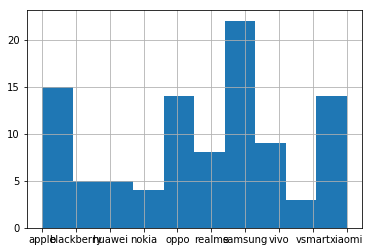

In [20]:
new_df = pre_processing_data()
new_df['companies'].hist()